# Freesolv Extraction/Postprocessing
This notebook: 
1. extracts the `espaloma-0.3.2` AHFE data
2. plots correlations with experiments
3. plots absolute residual CDFs with experimental data
4. performs PCA and plots the cumulative eigenspectrum of corresponding eigenvalues 

In [1]:
import os
import pickle
import typing
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from timemachine.datasets.utils import fetch_freesolv
from timemachine.fe.utils import get_mol_name
from timemachine.fe.refitting import query_name_dG_dG_err, ligand_charges_from_solvent_res, es_ss_qs_hs_from_mol_graph, embedding_pca
from timemachine.ff import make_mol_omm_sys
from timemachine.constants import KCAL_TO_KJ

from rdkit import Chem
from rdkit.Chem import Draw, AllChem

# esp stuff
import torch
import espaloma as esp

from openff.toolkit.topology import Molecule

esp_model = esp.get_model("latest")
matplotlib.rcParams['pdf.fonttype'] = 42  # save text as font, not path

The OpenEye Toolkits are found to be installed but not licensed and therefore will not be used.
The OpenEye Toolkits require a (free for academics) license, see https://docs.eyesopen.com/toolkits/python/quickstart-python/license.html
The OpenEye Toolkits are found to be installed but not licensed and therefore will not be used.
The OpenEye Toolkits require a (free for academics) license, see https://docs.eyesopen.com/toolkits/python/quickstart-python/license.html


In [2]:
all_freesolv_mols = fetch_freesolv()
len(all_freesolv_mols)

642

In [3]:
# this file must change to accommodate the location of the `.pkl` files for the AHFEs
pickle_path = '/data1/choderaj/rufad/tm/freesolv_esp'

In [ ]:
# extract data to a single set of lists
out_names, out_exp_dGs, out_calc_dGs, prefactors, ligand_charges = [], [], [], [], []
es, ss, hs = [], [], []
for idx, mol in enumerate(all_freesolv_mols):
    name, dG, dG_err = query_name_dG_dG_err(mol) # think these are in kcal/mol
    my_pkl_name = f"success_ahfe_result_{name}.pkl"
    my_file = os.path.join(pickle_path, my_pkl_name)
    try:
        with open(my_file, 'rb') as file:
            data = pickle.load(file)
    except Exception as e:
        print(idx)
        continue
    # pull data
    solvent_res, prefactors0, prefactors1 = data
    # protocol goes from 0 (decoupled) to 1 (coupled):
    # https://github.com/dominicrufa/timemachine/blob/30261bf1bb8bf4d77d90b814913b34dc463f6795/timemachine/fe/absolute_hydration.py#L162
    solvent_dg = sum(solvent_res.final_result.dGs) / KCAL_TO_KJ
    solvent_dg_err = np.linalg.norm(solvent_res.final_result.dG_errs) / KCAL_TO_KJ

    # retrieve charges
    qs = ligand_charges_from_solvent_res(solvent_res)
    
    out_names.append(name)
    out_calc_dGs.append([solvent_dg, solvent_dg_err])
    out_exp_dGs.append([dG, dG_err])
    prefactors.append(prefactors1)
    ligand_charges.append(qs)

    # es, ss, qs, hs
    charged_mol, omm_sys, tm_ff, molecule_graph = make_mol_omm_sys(mol, charge_spec = 'nn', esp_model=esp_model)
    _e, _s, _q, _h = es_ss_qs_hs_from_mol_graph(molecule_graph)
    es.append(_e)
    ss.append(_s)
    hs.append(_h)
    

/home/rufad/miniconda3/envs/tm_off/lib/python3.11/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


/home/rufad/miniconda3/envs/tm_off/lib/python3.11/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


In [ ]:
arr_exp_dGs = np.array(out_exp_dGs)
arr_calc_dGs = np.array(out_calc_dGs)

In [ ]:
# omit because this has been done previously
with open(f"agg_freesolv_data.pkl", "wb") as fh:
    pickle.dump((out_names, arr_exp_dGs, arr_calc_dGs, prefactors, ligand_charges, es, ss, hs), fh)

In [4]:
from timemachine.fe.refitting import load_pkl_data
data = load_pkl_data(f"agg_freesolv_data.pkl")
(out_names, arr_exp_dGs, arr_calc_dGs, prefactors, ligand_charges, es, ss, hs) = data

In [5]:
import networkx as nx
import numpy as np
import scipy
import sklearn.metrics
from typing import Union


def bootstrap_statistic(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    dy_true: Union[np.ndarray, None] = None,
    dy_pred: Union[np.ndarray, None] = None,
    ci: float = 0.95,
    statistic: str = "RMSE",
    nbootstrap: int = 1000,
    plot_type: str = "dG",
    include_true_uncertainty: bool = False,
    include_pred_uncertainty: bool = False,
) -> dict:

    """Compute mean and confidence intervals of specified statistic.

    Parameters
    ----------
    y_true : ndarray with shape (N,)
        True values
    y_pred : ndarray with shape (N,)
        Predicted values
    dy_true : ndarray with shape (N,) or None
        Errors of true values. If None, the values are assumed to have no errors
    dy_pred : ndarray with shape (N,) or None
        Errors of predicted values. If None, the values are assumed to have no errors
    ci : float, optional, default=0.95
        Interval for confidence interval (CI)
    statistic : str
        Statistic, one of ['RMSE', 'MUE', 'R2', 'rho','KTAU','RAE']
    nbootstrap : int, optional, default=1000
        Number of bootstrap samples
    plot_type : str, optional, default='dG'
        'dG' or 'ddG'
    include_true_uncertainty : bool, default False
        whether to account for the uncertainty in y_true when bootstrapping
    include_pred_uncertainty : bool, default False
        whether to account for the uncertainty in y_pred when bootstrapping

    Returns
    -------
    rmse_stats : dict of float
        'mean' : mean RMSE
        'stderr' : standard error
        'low' : low end of CI
        'high' : high end of CI
    """

    def compute_statistic(y_true_sample: np.ndarray, y_pred_sample: np.ndarray, statistic: str):
        """Compute requested statistic.

        Parameters
        ----------
        y_true : ndarray with shape (N,)
            True values
        y_pred : ndarray with shape (N,)
            Predicted values
        statistic : str
            Statistic, one of ['RMSE', 'MUE', 'R2', 'rho','RAE','KTAU']

        """

        def calc_RAE(y_true_sample: np.ndarray, y_pred_sample: np.ndarray):
            MAE = sklearn.metrics.mean_absolute_error(y_true_sample, y_pred_sample)
            mean = np.mean(y_true_sample)
            MAD = np.sum([np.abs(mean - i) for i in y_true_sample]) / float(len(y_true_sample))
            return MAE / MAD

        def calc_RRMSE(y_true_sample: np.ndarray, y_pred_sample: np.ndarray):
            rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_true_sample, y_pred_sample))
            mean_exp = np.mean(y_true_sample)
            mds = np.sum([(mean_exp - i) ** 2 for i in y_true_sample]) / float(len(y_true_sample))
            rrmse = np.sqrt(rmse**2 / mds)
            return rrmse

        if statistic == "RMSE":
            return np.sqrt(sklearn.metrics.mean_squared_error(y_true_sample, y_pred_sample))
        elif statistic == "MUE":
            return sklearn.metrics.mean_absolute_error(y_true_sample, y_pred_sample)
        elif statistic == "R2":
            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
                y_true_sample, y_pred_sample
            )
            return r_value**2
        elif statistic == "rho":
            return scipy.stats.pearsonr(y_true_sample, y_pred_sample)[0]
        elif statistic == "RAE":
            return calc_RAE(y_true_sample, y_pred_sample)
        elif statistic == "KTAU":
            return scipy.stats.kendalltau(y_true_sample, y_pred_sample)[0]
        else:
            raise Exception("unknown statistic '{}'".format(statistic))

    # not used?
    def unique_differences(x):
        """Compute all unique differences"""
        N = len(x)
        return np.array([(x[i] - x[j]) for i in range(N) for j in range(N) if (i != j)])

    if dy_true is None:
        dy_true = np.zeros_like(y_true)
    if dy_pred is None:
        dy_pred = np.zeros_like(y_pred)
    assert len(y_true) == len(y_pred)
    assert len(y_true) == len(dy_true)
    assert len(y_true) == len(dy_pred)
    sample_size = len(y_true)
    s_n = np.zeros(
        [nbootstrap], np.float64
    )  # s_n[n] is the statistic computed for bootstrap sample n
    for replicate in range(nbootstrap):
        y_true_sample = np.zeros_like(y_true)
        y_pred_sample = np.zeros_like(y_pred)
        for i, j in enumerate(
            np.random.choice(np.arange(sample_size), size=[sample_size], replace=True)
        ):
            stddev_true = np.fabs(dy_true[j]) if include_true_uncertainty else 0
            stddev_pred = np.fabs(dy_pred[j]) if include_pred_uncertainty else 0
            y_true_sample[i] = np.random.normal(loc=y_true[j], scale=stddev_true, size=1)[0]
            y_pred_sample[i] = np.random.normal(loc=y_pred[j], scale=stddev_pred, size=1)[0]
        s_n[replicate] = compute_statistic(y_true_sample, y_pred_sample, statistic)

    rmse_stats = dict()
    rmse_stats["mle"] = compute_statistic(y_true, y_pred, statistic)
    rmse_stats["stderr"] = np.std(s_n)
    rmse_stats["mean"] = np.mean(s_n)
    # TODO: Is there a canned method to do this?
    s_n = np.sort(s_n)
    low_frac = (1.0 - ci) / 2.0
    high_frac = 1.0 - low_frac
    rmse_stats["low"] = s_n[int(np.floor(nbootstrap * low_frac))]
    rmse_stats["high"] = s_n[int(np.ceil(nbootstrap * high_frac))]

    return rmse_stats



In [6]:
statistics = {'RMSE': None, 'MUE': None, 'R2': None}
for key in statistics.keys():
    _list = bootstrap_statistic(
        y_true = arr_exp_dGs[:,0],
        y_pred = arr_calc_dGs[:,0],
        dy_true = arr_exp_dGs[:,1],
        dy_pred = arr_calc_dGs[:,1],
        statistic = key,
        nbootstrap = 1000,
        plot_type = "dG",
        include_true_uncertainty = False,
        include_pred_uncertainty = False,
    )
    statistics[key] = _list

In [8]:
N_mols = len(arr_exp_dGs)

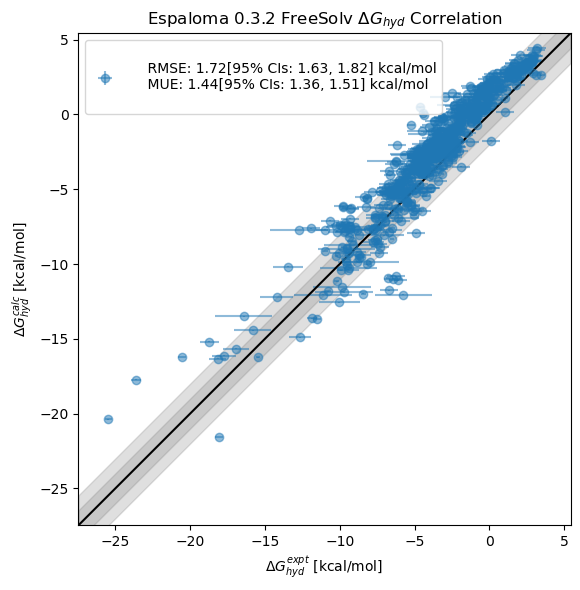

In [9]:
default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

ax.errorbar(
    arr_exp_dGs[:,0], arr_calc_dGs[:,0], 
    xerr = arr_exp_dGs[:,1], yerr = arr_calc_dGs[:,1], ls='none', marker='o', alpha=0.5, 
    label=f"""
    RMSE: {statistics['RMSE']['mean']:.2f}[95% CIs: {statistics['RMSE']['low']:.2f}, {statistics['RMSE']['high']:.2f}] kcal/mol
    MUE: {statistics['MUE']['mean']:.2f}[95% CIs: {statistics['MUE']['low']:.2f}, {statistics['MUE']['high']:.2f}] kcal/mol
    """)
ax.set_xlabel(r"$\Delta G_{hyd}^{expt}$ [kcal/mol]")
ax.set_ylabel(r"$\Delta G_{hyd}^{calc}$ [kcal/mol]")

x = np.linspace(arr_exp_dGs[:,0].min() - 2, arr_exp_dGs[:,0].max() + 2, 1000)
y1 = x + 1.
y2 = x - 1.
ax.set_title(r"Espaloma 0.3.2 FreeSolv $\Delta G_{hyd}$ Correlation")
ax.legend(loc='upper left')
ax.set_xlim(arr_exp_dGs[:,0].min() - 2, arr_exp_dGs[:,0].max() + 2)
ax.set_ylim(arr_exp_dGs[:,0].min() - 2, arr_exp_dGs[:,0].max() + 2)
# Automatically scale axes
#ax.autoscale_view()
ax.plot(x, x, color='k')
ax.fill_between(x, y1, y2, color='grey', alpha=0.25)
ax.fill_between(x, y1 + 1, y2 - 1, color='grey', alpha=0.25)
ax.set_aspect('equal', adjustable='box')  # Keep plot square


plt.tight_layout()
#plt.show()

plt.savefig("esp032_FreeSolv_dG.1.pdf", format="pdf", dpi=300)

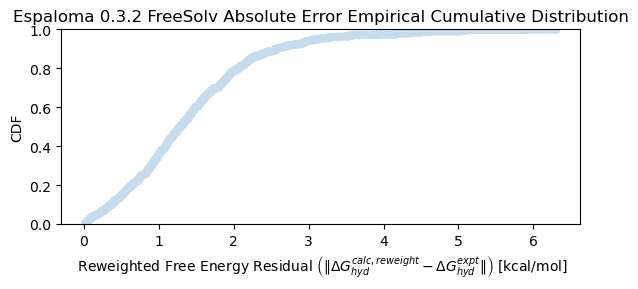

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3))
orig_resids = np.abs(arr_exp_dGs[:,0] - arr_calc_dGs[:,0])
ax.ecdf(orig_resids, color = default_colors[0], label = f"Espaloma 0.3.2", alpha = 0.25, lw=6)
ax.set_title(r"Espaloma 0.3.2 FreeSolv Absolute Error Empirical Cumulative Distribution")
ax.set_xlabel(r" Reweighted Free Energy Residual $\left( \| \Delta G_{hyd}^{calc, reweight}  - \Delta G_{hyd}^{expt} \| \right)$ [kcal/mol]")
#ax.set_xlabel(r" $\| \Delta G_{hyd}^{calc}  - \Delta G_{hyd}^{expt} \| $ [kcal/mol]")
ax.set_ylabel(f"CDF")


plt.tight_layout()
plt.savefig("esp032_FreeSolv_dG.2.pdf", format="pdf", dpi=300)
#plt.show()

In [12]:
stacked_hs = np.vstack(hs)
eigenvalues, eigenvectors = embedding_pca(stacked_hs)
cum_eigs = np.cumsum(eigenvalues)
normalized_cum_eigs = cum_eigs / np.max(cum_eigs)

In [20]:
def closest_to(arr, target):
    # Convert to numpy array for easy manipulation
    arr = np.array(arr)
    absolute_errors = np.abs(arr - target)
    return np.argmin(absolute_errors)

In [21]:
normalized_fractions = np.cumsum(eigenvalues) / np.cumsum(eigenvalues)[-1]
fraction_matches = [0.5, 0.75, 0.95, 0.99]
my_match_indices = [closest_to(normalized_fractions, f) for f in fraction_matches]


In [23]:
my_match_values = [np.cumsum(eigenvalues)[q] for q in my_match_indices]

In [35]:
my_match_indices

[4, 18, 95, 238]

In [34]:
my_match_values

[2.087881, 3.2414958, 4.089576, 4.2613034]

In [24]:
my_match_values

[2.087881, 3.2414958, 4.089576, 4.2613034]

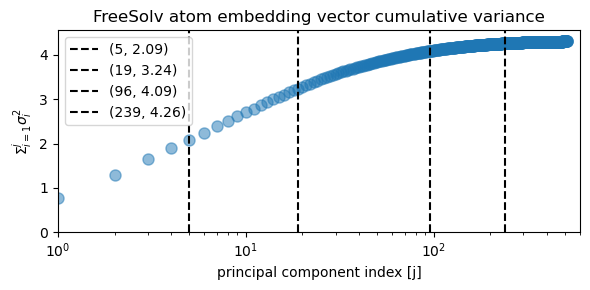

In [54]:
fig, ax = plt.subplots(figsize=(6,3))

ax.plot(np.arange(len(np.cumsum(eigenvalues)))+1, np.cumsum(eigenvalues), marker='o', ls='none', alpha=0.5, markersize=8)
ax.set_xscale('log')
ax.set_xlabel(f"principal component index [j]")
ax.set_ylabel(r"$\Sigma_{i=1}^j \sigma_i^2$")
ax.set_title(f"FreeSolv atom embedding vector cumulative variance")
for eig_idx, my_percentile, cum_percent in zip(my_match_indices, my_match_values, fraction_matches):
    plt.axvline(x=eig_idx+1, color='k', linestyle='--', label=f"({eig_idx+1}, {my_percentile:.2f})")
plt.legend()
    
plt.ylim(0, cum_eigs[-1] + 0.25)
plt.xlim(1, 600)
#ax.set_aspect('equal')  # Keep plot square
plt.tight_layout()
#plt.show()

plt.savefig("AEV_PCA_eigenspectrum.pdf", format="pdf", dpi=300)